In [34]:
import pandas as pd
from config import *

df = pd.read_csv(all)

C:\Users\benja\AppData\Local\Temp\ipykernel_17192\2130263240.py:4: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(all)


In [35]:
from filtering import formatDF, discretizarDatos
data = formatDF(df)
data.loc[data["vendedor"].isna(), "vendedor"] = data.loc[data["vendedor"].isna(), "tipoVendedor"]
data = discretizarDatos(data)

# drop columns: activo, URL, file, tipoVendedor, ciudad
data = data.drop(['activo', 'URL', 'file', 'tipoVendedor','ciudad'], axis=1)
data = data.loc[data["tipoPropiedad"] != 3]
data['barrio'] = data['barrio'].astype('category').cat.codes

C:\Users\benja\AppData\Local\Temp\ipykernel_17192\3200405269.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  data = formatDF(df)


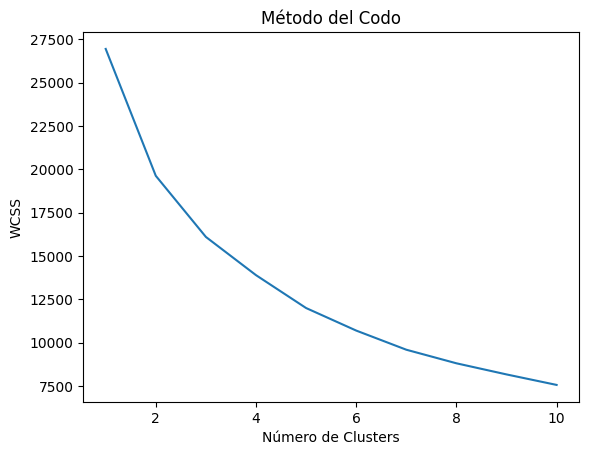

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrio']
data_for_clustering = data[features]

# Escalar los datos para que todas las características tengan la misma escala
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Determinar el número óptimo de clusters utilizando el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=100, random_state=33)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Visualizar el método del codo para encontrar el número óptimo de clusters
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()


In [37]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_init=200, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Agregar la información de los clusters al DataFrame original
data['clusterKM'] = clusters

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

features_knn = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
                'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrio']

data_for_knn_train = data[features_knn]
target_column = 'precioUSD'
target = data[target_column]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_for_knn_train, target, train_size=0.99, random_state=33)

# Eliminar train_test_split y usar todo el conjunto de entrenamiento
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)

# Crear instancias de modelos con diferentes configuraciones
models = dict()
r2_scores = []
for i in range(1, 20):
    models[f'knn{i}'] = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m = models[f'knn{i}']
    m.fit(X_train_scaled, y_train)
    scores_r2 = cross_val_score(m, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_scores.append((f'knn{i}', scores_r2.mean()))

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Entrenando modelos...")

print("Random Forest...")
random_forest_model = RandomForestRegressor(n_estimators=800, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

print("Gradient Boosting...")
gradient_boosting_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=8, random_state=42)
gradient_boosting_model.fit(X_train_scaled, y_train)

print("Modelos entrenados.")

random_forest_r2 = cross_val_score(random_forest_model, X_train_scaled, y_train, cv=5, scoring='r2')
gradient_boosting_r2 = cross_val_score(gradient_boosting_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("\nRandom Forest:")
print(f"R^2: {random_forest_r2.mean()}")
print("\nGradient Boosting:")
print(f"R^2: {gradient_boosting_r2.mean()}")


Random Forest:
RMSE: 26263.718663068485
R^2: 0.7699242127150334

Gradient Boosting:
RMSE: 27929.11311761659
R^2: 0.7747903092787223


In [108]:
sorted_models = [model[0] for model in sorted(r2_scores, key=lambda x: x[1], reverse=True)][:8]
models_w_weight = []
weights = [4,3,3,2,2,1,1]
for i in range(len(weights)):
    models_w_weight.append(((sorted_models[i], models[sorted_models[i]]), weights[i]))
    
models_w_weight.append((('RF', random_forest_model), 4))
models_w_weight.append((('XGBoost', gradient_boosting_model), 4))

In [110]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

ensemble_model = VotingRegressor(estimators=[model[0] for model in models_w_weight], 
                                 weights=[w[1] for w in models_w_weight])
ensemble_model.fit(X_train_scaled, y_train)

# Escalar todos los datos
X_testing = X_test.copy()
X_test_scaled = scaler_knn.transform(X_test)
all_data_predictions = ensemble_model.predict(X_test_scaled)
X_testing.loc[:, 'precioUSDPredicted'] = all_data_predictions

ensemble_r2 = r2_score(y_test, all_data_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, all_data_predictions))

# Imprimir resultados
print(f"R^2 en el conjunto de prueba para el modelo ensamblado: {ensemble_r2}")
print(f"RMSE del modelo ensamblado: {ensemble_rmse}")

R^2 en el conjunto de prueba para el modelo ensamblado: 0.9091689839986068
RMSE del modelo ensamblado: 24668.945177152473


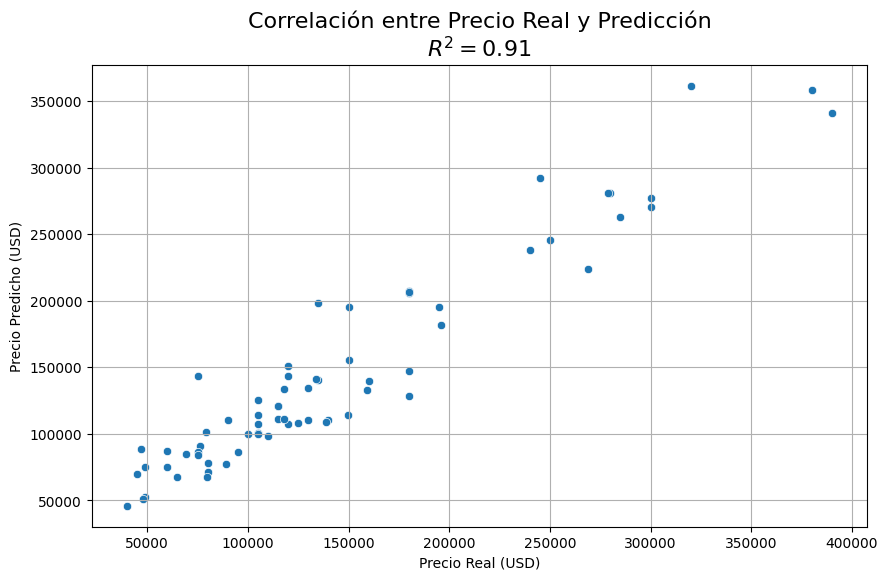

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

# Calcula el R^2 para mostrarlo en el gráfico
ensemble_r2 = r2_score(y_test, all_data_predictions)

# Crea un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=all_data_predictions)
plt.title(f'Correlación entre Precio Real y Predicción\n$R^2={ensemble_r2:.2f}$', fontsize=16)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)
plt.show()

In [ ]:
X_testing.to_excel('predicciones.xlsx')